## Loading necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

C:\Users\Adrian\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


True

## Loading and preprocessing images

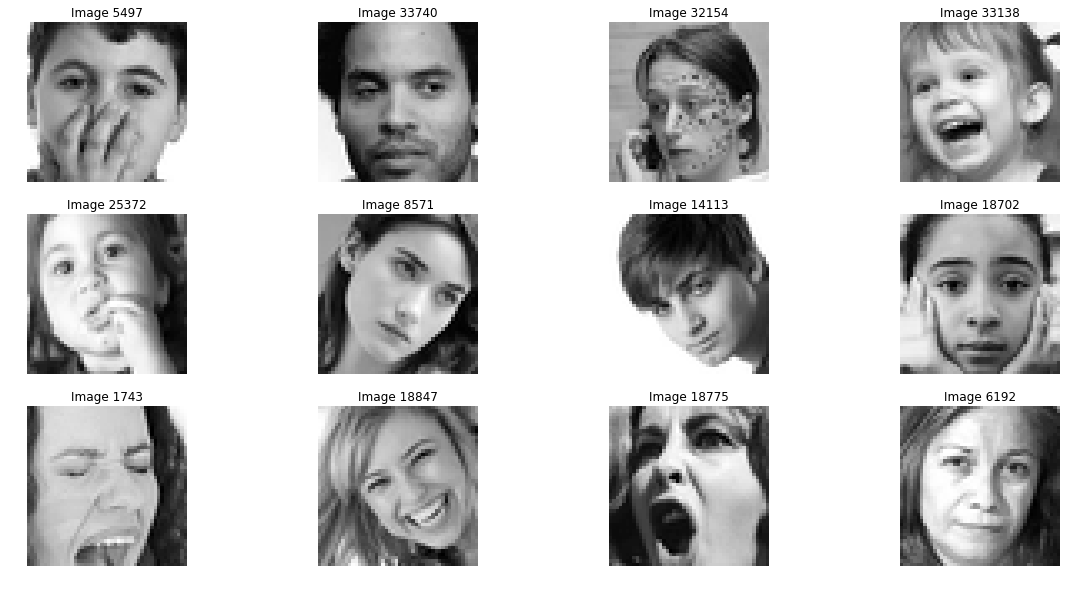

In [2]:
# Read the data
data = pd.read_csv("fer2013.csv")

pixels_values = data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)


# Function for displaying 12 random images
def show(img):
    random_numbers = np.random.randint(0, len(img), 12)
    plt.figure(figsize=(20, 10)) 
    for index, number in enumerate(random_numbers):
        show_image = images[number].reshape(48,48)
        plt.subplot(3,4,index+1)
        plt.title('Image' + ' ' +str(number))
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
show(images)


# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [5]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

## Building CNN

In [ ]:
# Construct CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 4th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected neural networks
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 64)        36928     
__________

## Training CNN using Data Augmentation

In [ ]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


# Saving model each time it achieves lower loss on the validation set
filepath='Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    nb_epoch=300,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=[checkpointer,tensorboard]
                             )


## Loading best model and exploring the results

In [2]:
model2 = load_model('Best_model_6759OffTest.hdf5')

In [7]:
scores = model2.evaluate(np.array(X_test), np.array(y_test), batch_size=256)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

3589/3589 [==============================] - 6s 2ms/step
Loss: 0.9219519488490634
Accuracy: 0.6759543048368918


In [146]:
history = pd.read_csv('history.csv', usecols = ['acc','loss','val_acc','val_loss'])

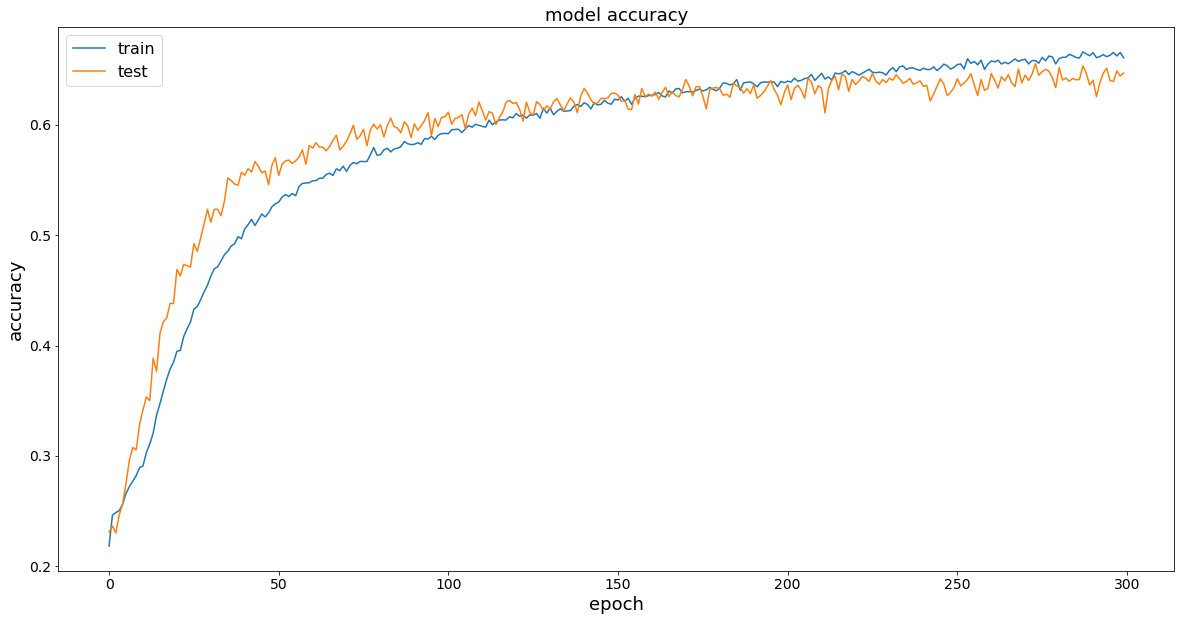

In [173]:
plt.figure(figsize=(20, 10)) 
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy', fontsize = 18)
plt.ylabel('accuracy', fontsize = 18)
plt.xlabel('epoch', fontsize = 18)
plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

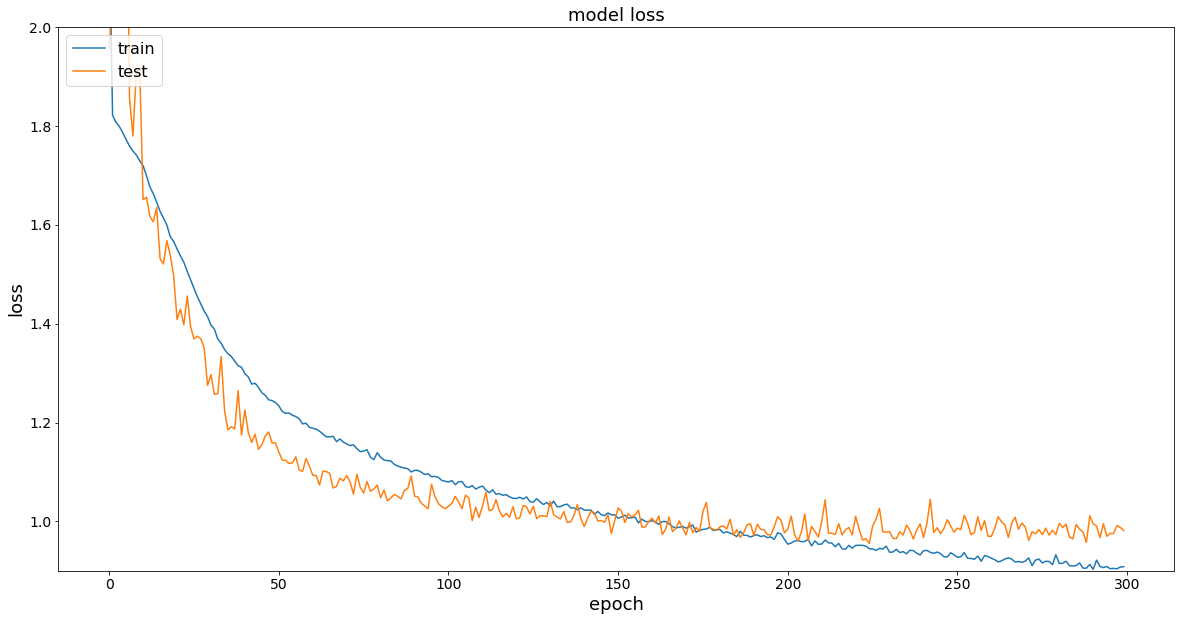

In [174]:
plt.figure(figsize=(20, 10)) 
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss', fontsize = 18)
plt.ylabel('loss', fontsize = 18)
plt.xlabel('epoch', fontsize = 18)
plt.ylim(0.9,2)
plt.legend(['train', 'test'], loc='upper left', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [9]:
import cv2
from scipy.ndimage import zoom

def extract_face_features(gray, detected_face, offset_coefficients):
        (x, y, w, h) = detected_face
        #print x , y, w ,h
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        extracted_face = gray[y+vertical_offset:y+h, 
                          x+horizontal_offset:x-horizontal_offset+w]
        #print extracted_face.shape
        new_extracted_face = zoom(extracted_face, (48. / extracted_face.shape[0], 
                                                   48. / extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max())
        return new_extracted_face
    

def detect_face(frame):
        cascPath = "haarcascade_frontalface_default.xml"
        faceCascade = cv2.CascadeClassifier(cascPath)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        detected_faces = faceCascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=6,
                minSize=(48, 48),
                #flags=cv2.CV_HAAR_FEATURE_MAX
            )
        return gray, detected_faces


cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    ret, frame = video_capture.read()

    # detect faces
    gray, detected_faces = detect_face(frame)
    
    face_index = 0
    
    # predict output
    for face in detected_faces:
        (x, y, w, h) = face
        if w > 100:
            # draw rectangle around face 
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # extract features
            extracted_face = extract_face_features(gray, face, (0.075, 0.05)) #(0.075, 0.05)

            # predict smile
            prediction_result = model4.predict_classes(extracted_face.reshape(1,48,48,1))

            # draw extracted face in the top right corner
            frame[face_index * 48: (face_index + 1) * 48, -49:-1, :] = cv2.cvtColor(extracted_face * 255, cv2.COLOR_GRAY2RGB)

            # annotate main image with a label
            if prediction_result == 3:
                cv2.putText(frame, "Happy",(x,y), cv2.FONT_ITALIC, 2, 155, 10)
            elif prediction_result == 0:
                cv2.putText(frame, "Angry",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 1:
                cv2.putText(frame, "Disgust",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 2:
                cv2.putText(frame, "Fear",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 4:
                cv2.putText(frame, "Sad",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 5:
                cv2.putText(frame, "Surprise",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            else :
                cv2.putText(frame, "Neutral",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            

            # increment counter
            face_index += 1
                

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

C:\Users\Adrian\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


<img src='face/neutral.png' width="350">
<img src='face/happy2.png' width="350">
<img src='face/angry.png' width="350">
<img src='face/fear.png' width="350">
<img src='face/sad2.png' width="350">
<img src='face/surprise.png' width="350">